# House Prices Advanced Regression Techniques 2

This is the next part of "House Price.ipynb" where  will try alternative methods to predict the house prices.

## Rounding to 50

If we look at the SalePrice of train set, we can see most of them are dividend to 50. So we will change the post-process a little bit.

In [1]:
%matplotlib inline
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

df_dividend_50 = df_train.loc[df_train['SalePrice'] % 50 == 0]
percentage = len(df_dividend_50) / len(df_train)
print(f'{percentage:.2%} of the SalePrice are dividend to 50.')

93.22% of the SalePrice are dividend to 50.


That's a lot. We expect test set would be like so.

In [3]:

from sklearn.linear_model import Lasso
from sklearn.ensemble import VotingRegressor
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor

In [4]:
df_train['SalePriceLog1p'] = np.log1p(df_train['SalePrice'])

The best params are taken from "House Price.ipynb".

In [5]:
kernel_ridge = KernelRidge(**{'alpha': 0.001, 'gamma': 0.001, 'kernel': 'rbf'})
lasso = Lasso(random_state=0, **{'alpha': 0.0001})
lightgbm = LGBMRegressor(random_state=0, **{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100})

voting_regressor = VotingRegressor(
    estimators=[
        ('kernel_ridge', kernel_ridge),
        ('lasso', lasso),
        ('lightgbm', lightgbm),
    ],
    n_jobs=-1,
    verbose=1
)

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from scipy import stats

In [7]:
high_correlated_with_sale_price = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd',
                                   'AgeBuilt', 'AgeRemodAdd']

tobe_normalized_cols = high_correlated_with_sale_price.copy()

selected_columns = ['NormalizedOverallQual', 'NormalizedGrLivArea', 'NormalizedGarageCars', 'NormalizedTotalBsmtSF',
                    'NormalizedFullBath', 'NormalizedTotRmsAbvGrd', 'NormalizedAgeBuilt', 'NormalizedAgeRemodAdd',
                    'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
                    'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
                    'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
                    'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
                    'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
                    'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
                    'Neighborhood_Veenker']

The whole process is similar to part 1 except the post-process.

In [8]:
def fill_missing(df: pd.DataFrame):
    print('Fill missing values')
    continuous_imputer = SimpleImputer(strategy='median')
    discrete_imputer = SimpleImputer(strategy='most_frequent')

    continuous_columns_ = df.select_dtypes(include=['float64', 'int64']).columns
    discrete_columns_ = df.select_dtypes(include=['object']).columns

    df[continuous_columns_] = continuous_imputer.fit_transform(df[continuous_columns_])
    df[discrete_columns_] = discrete_imputer.fit_transform(df[discrete_columns_])

    return df

def year_to_age(df: pd.DataFrame):
    print('Convert year columns to age columns')
    df['AgeBuilt'] = 2016 - df['YearBuilt']
    df['AgeRemodAdd'] = 2016 - df['YearRemodAdd']
    return df

def normalize_continuous_data(df: pd.DataFrame):
    print(f'Normalize: {tobe_normalized_cols}')

    for c in tobe_normalized_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[f'Normalized{c}'] = stats.boxcox(df[c], lmbda=0.2)

    return df

def encode_discrete_data(df: pd.DataFrame):
    print(f'Try to encode Neighbourhood')
    if 'Neighborhood' in df.columns:
        df = pd.get_dummies(df, columns=['Neighborhood'])
    else:
        print('Neighborhood not found')
    return df

def select_features(df: pd.DataFrame):
    print(f'Select features {selected_columns}')
    print('Make sure all columns are numeric')
    for c in selected_columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df[selected_columns]

def inverse_log_transform(sale_price_log1p: pd.Series) ->  pd.Series:
    print('Inverse log transform')
    return np.expm1(sale_price_log1p)

def round_nearest_50(sale_price: pd.Series) ->  pd.Series:
    print('Round value to 50')
    return (sale_price / 50).round() * 50

In [9]:
preprocess_pipeline = make_pipeline(
    FunctionTransformer(fill_missing, validate=False),
    FunctionTransformer(year_to_age, validate=False),
    FunctionTransformer(normalize_continuous_data, validate=False),
    FunctionTransformer(encode_discrete_data, validate=False),
    FunctionTransformer(select_features, validate=False),
)

postprocess_pipeline = make_pipeline(
    FunctionTransformer(inverse_log_transform, validate=False),
    FunctionTransformer(round_nearest_50, validate=False),
)

complete_pipeline = make_pipeline(
    preprocess_pipeline,
    voting_regressor,
    postprocess_pipeline
)

complete_pipeline.fit(df_train, df_train['SalePriceLog1p'])

Fill missing values
Convert year columns to age columns
Normalize: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'AgeBuilt', 'AgeRemodAdd']
Try to encode Neighbourhood
Select features ['NormalizedOverallQual', 'NormalizedGrLivArea', 'NormalizedGarageCars', 'NormalizedTotalBsmtSF', 'NormalizedFullBath', 'NormalizedTotRmsAbvGrd', 'NormalizedAgeBuilt', 'NormalizedAgeRemodAdd', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Ve

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function fill_missing at 0x0000023EB39E49A0>)),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=<function year_to_age at 0x0000023EB39E4A40>)),
                                 ('functiontransformer-3',
                                  FunctionTransformer(func=<function normalize_continuous_data at 0x0000023EB39E4B80>)),
                                 ('funct...
                                              Lasso(alpha=0.0001,
                                                    random_state=0)),
                                             ('lightgbm',
                                              LGBMRegressor(max_depth=5,
                                                            random_state=0))],
                                 n_jobs=-1, verbose=1)),
                ('pipeline-2',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function inverse_log_transform at 0x0000023EB39E4D60>)),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=<function round_nearest_50 at 0x0000023EB39E4E00>))]))])

Read test set and predict.

In [10]:
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

preprocess_test = preprocess_pipeline.transform(df_test)
predictions = voting_regressor.predict(preprocess_test)
post_predictions = postprocess_pipeline.transform(predictions)

Fill missing values
Convert year columns to age columns
Normalize: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'AgeBuilt', 'AgeRemodAdd']
Try to encode Neighbourhood
Select features ['NormalizedOverallQual', 'NormalizedGrLivArea', 'NormalizedGarageCars', 'NormalizedTotalBsmtSF', 'NormalizedFullBath', 'NormalizedTotRmsAbvGrd', 'NormalizedAgeBuilt', 'NormalizedAgeRemodAdd', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Ve

And visualize the result.

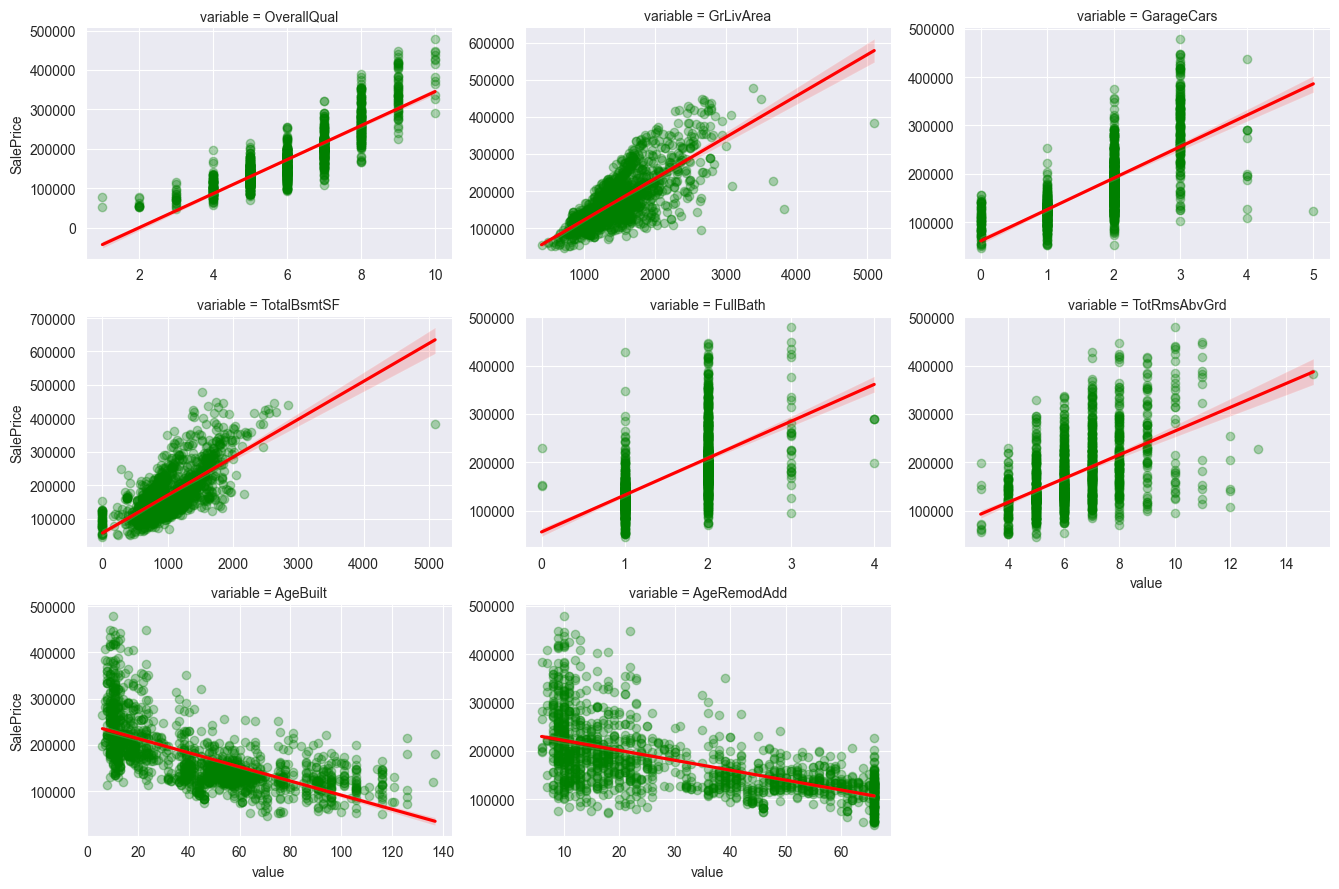

In [11]:
df_test['SalePrice'] = post_predictions
sns.FacetGrid(
    pd.melt(df_test, id_vars=['SalePrice'], value_vars=high_correlated_with_sale_price),
    col='variable',
    col_wrap=3,
    aspect=1.5,
    sharex=False,
    sharey=False,
).map(
    sns.regplot,
    'value',
    'SalePrice',
    color='g',
    scatter_kws={'alpha':0.3},
    line_kws={'color':'red'}
)

<Axes: xlabel='SalePrice', ylabel='Density'>

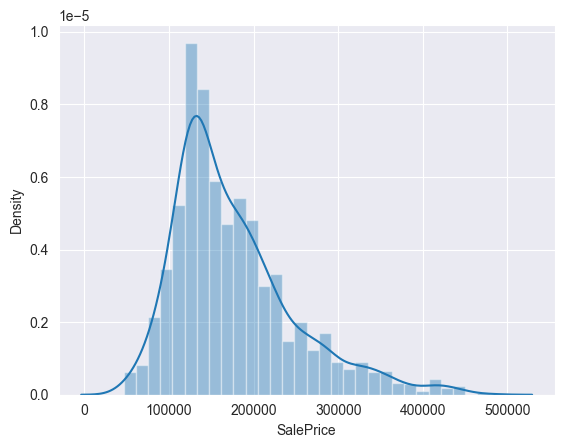

In [12]:
sns.distplot(df_test['SalePrice'], kde=True)

Save the result.

In [13]:
# df_test['Id'] = df_test['Id'].astype(int)
# df_test[['Id', 'SalePrice']].to_csv('../input/house-prices-advanced-regression-techniques/submission/voting-regression-v2.1.csv', index=False)